In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

!pip install optuna
!pip install timm
!pip install scikit-learn
!pip install pandas
!pip install seaborn

torch version: 1.13.1
torchvision version: 0.14.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 6.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 44.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.7/613.7 kB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 9.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 47.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 47.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 55.2 MB/s eta 0:00:0000:0100:01
     ━━

In [2]:
# Continue with regular imports
!pip install matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary
!pip install ipython-autotime
%load_ext autotime

[INFO] Couldn't find torchinfo... installing it.
time: 440 µs (started: 2023-04-23 10:04:27 +00:00)


In [ ]:
#upload a kaggle.json file before running this code. The json file can be obtained through your account settings in kaggle
!pip install -q kaggle
!apt-get install -y unzip
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d andrewmvd/isic-2019
!unzip /isic-2019.zip

In [4]:
import numpy as np
import pandas as pd

# read in ground truth data from a CSV file and store it in a Pandas DataFrame
groundtruth = '/ISIC_2019_Training_GroundTruth.csv'
groundtruthdf = pd.read_csv(groundtruth)

# create a new DataFrame containing column names where the value is 1 in the ground truth DataFrame
dxrow = pd.DataFrame([x for x in np.where(groundtruthdf == 1, groundtruthdf.columns,'').flatten().tolist() if len(x) > 0], columns= (["dx"]))

# read in metadata from a CSV file and store it in a Pandas DataFrame
metadata = '/ISIC_2019_Training_Metadata.csv'
metadatadf = pd.read_csv(metadata)

# merge the metadata and ground truth DataFrames on their intersection
data = pd.concat([metadatadf, dxrow], axis=1, join='inner')

# print the first few rows of the resulting DataFrame
data.head()

# print the first few rows of the ground truth DataFrame
groundtruthdf.head()

# create a dictionary mapping class names to directories containing corresponding training data
class_dict = {'MEL': 'MEL/',
              'NV': 'NV/',
              'BCC': 'BCC/',
              'AK': 'AK/',
              'BKL': 'BKL/',
              'DF': 'DF/',  
              'VASC': 'VASC/',    
              'SCC': 'SCC/'}


time: 264 ms (started: 2023-04-23 10:09:30 +00:00)


In [5]:
#this code splits the directory that contains all the images, into a 
#train/val/test split with a 80/10/10 ratio

import os
import shutil
import random

# Set the random seed for reproducibility
torch.manual_seed(42)

#define the path files
image_dir = '/ISIC_2019_Training_Input/ISIC_2019_Training_Input'
path = '/data/'
train_dir = '/data/train/'
val_dir = '/data/valid/'
test_dir = '/data/test/'

# Create the destination directories for the training, validation, and testing sets
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

train_set = set()
valid_set = set()
test_set = set()

for index, row in data.iterrows():
    image_file = row['image']
    class_label = row['dx']
    
    # Randomly assign 80% of the images to train set, 10% to validation set and 10% to test set. 
    rand_num = random.random()
    if rand_num < 0.8:
        dest_dir = os.path.join(train_dir, class_dict[class_label])
        train_set.add(image_file)
    elif rand_num < 0.9:
        dest_dir = os.path.join(val_dir, class_dict[class_label])
        valid_set.add(image_file)
    else:
        dest_dir = os.path.join(test_dir, class_dict[class_label])
        test_set.add(image_file)
    
    # Create the destination directory if it doesn't exist
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    
    # Copy the image file to the destination directory
    src_path = os.path.join(image_dir, image_file + '.jpg')
    dest_path = os.path.join(dest_dir, image_file + '.jpg')
    shutil.copy(src_path, dest_path)

 # Print class distribution for the training, validation and testing sets
print("Training Set Class Distribution:")
train_total = 0
for class_label in class_dict.values():
    class_path = os.path.join(train_dir, class_label)
    num_images = len(os.listdir(class_path))
    train_total += num_images
    print(f"{class_label}: {num_images}")
print(f"Total images in training set: {train_total}")

print("\nValidation Set Class Distribution:")
val_total = 0
for class_label in class_dict.values():
    class_path = os.path.join(val_dir, class_label)
    num_images = len(os.listdir(class_path))
    val_total += num_images
    print(f"{class_label}: {num_images}")
print(f"Total images in validation set: {val_total}")

print("\nTesting Set Class Distribution:")
test_total = 0
for class_label in class_dict.values():
    class_path = os.path.join(test_dir, class_label)
    num_images = len(os.listdir(class_path))
    test_total += num_images
    print(f"{class_label}: {num_images}")
print(f"Total images in testing set: {test_total}")


Training Set Class Distribution:
MEL/: 3584
NV/: 10254
BCC/: 2654
AK/: 705
BKL/: 2071
DF/: 190
VASC/: 196
SCC/: 492
Total images in training set: 20146

Validation Set Class Distribution:
MEL/: 469
NV/: 1321
BCC/: 327
AK/: 87
BKL/: 280
DF/: 27
VASC/: 29
SCC/: 72
Total images in validation set: 2612

Testing Set Class Distribution:
MEL/: 469
NV/: 1300
BCC/: 342
AK/: 75
BKL/: 273
DF/: 22
VASC/: 28
SCC/: 64
Total images in testing set: 2573
time: 6.91 s (started: 2023-04-23 10:09:30 +00:00)


In [6]:
# Set the random seed for reproducibility
torch.manual_seed(42)

# Get a set of pretrained model weights
weights = torchvision.models.MaxVit_T_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

# define the transform function that will be used in imagefolder to preprocess the data for MaxViT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[224]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

time: 5.53 ms (started: 2023-04-23 10:09:37 +00:00)


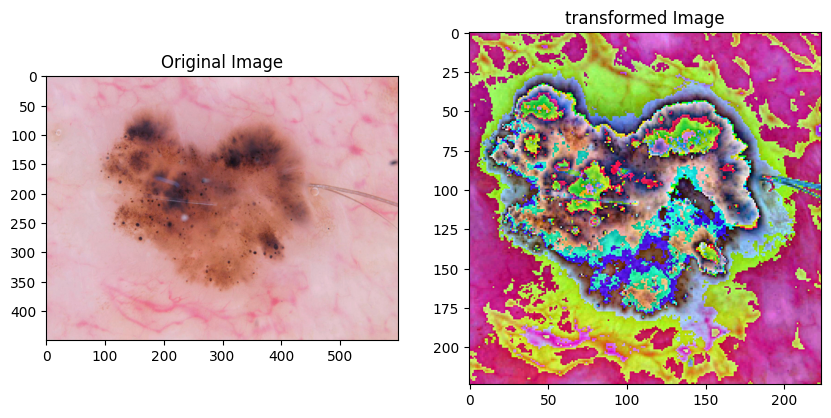

time: 470 ms (started: 2023-04-23 10:10:18 +00:00)


In [8]:
#show the image after applying transform, the picture looks distorted because 
#we have applied normalization 

import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the input image

image_path = 'data/train/BCC/ISIC_0027229.jpg'
input_image = Image.open(image_path)

# Apply the transforms function to the input image
auto_transformsimg = auto_transforms(input_image)

# Convert the tensor back to an image for visualization
auto_transformsimg = transforms.ToPILImage()(auto_transformsimg)

# Display the original and transformed images side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(input_image)
axs[0].set_title('Original Image')
axs[1].imshow(auto_transformsimg)
axs[1].set_title('transformed Image')
plt.show()

In [9]:
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import optuna
import timm
import torch.utils.data.sampler as sampler
from torch.utils.data import Subset
from torch.utils.data.sampler import RandomSampler
import torchvision.datasets as datasets

# Set the random seed for reproducibility
torch.manual_seed(42)

# Creates once at the beginning of training
scaler = torch.cuda.amp.GradScaler()

#define hyperparameter tuning, furthermore we will use 
#10 trials to look for the best hyperparameters. We re-used the optuna hyperparameter
#optimization code 

# Define the dataset and dataloader
def get_data_loaders(batch_size):

# Load and transform the data

    # Load the datasets
    train_dataset = datasets.ImageFolder(root='data/train', transform=auto_transforms)
    val_dataset = datasets.ImageFolder(root='data/valid', transform=auto_transforms)

    # load the data and shuffle the training data
    train_dataloader = data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
    valid_dataloader = data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

    return train_dataloader, valid_dataloader


def get_model(trial, dropout):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_name = 'mvitv2_large'
    model = timm.create_model(model_name, pretrained=True, num_classes=8)

    # Freeze the weights
    for param in model.parameters():
        param.requires_grad = False
   
    # Unfreeze the last fc layer
    for param in model.head.parameters():
        param.requires_grad = True

    # Add a dropout layer to the fc sequential block in the ClassifierHead
    model.head.fc = nn.Sequential(
        nn.Dropout(p=dropout),
        nn.Linear(model.head.fc.in_features, model.head.fc.out_features)
    )

    return model

# Define the objective function for Optuna
def objective(trial):
    # Get the hyperparameters to optimize
    batch_size = 32  # set batch size to 32
    epochs = 20  # set epochs to 20
    optimizer_name = trial.suggest_categorical("optimizer_name", ["AdamW", "SGD"])
    weight_decay = 0.0
    if optimizer_name == "SGD":
      weight_decay = trial.suggest_float("weight_decay", low=0.001, high=0.01, log=True)
    learning_rate = trial.suggest_float("learning_rate", low=0.001, high=0.01, log=True)
    dropout = trial.suggest_categorical("dropout", [0.0, 0.25, 0.5])

    # Get the data loaders
    train_dataloader, valid_dataloader = get_data_loaders(batch_size)

    # Get the model
    model = get_model(trial, dropout)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    # Define the optimizer and loss function
    if optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Initialize variables for early stopping
    best_accuracy = 0.0
    patience = 5
    no_improvement_count = 0

   # Train the model with early stopping
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                scaler.scale(loss).backward()    # Scale the gradients
                scaler.step(optimizer)           # Update the model parameters
                scaler.update()                  # Update the scaler

            running_loss += loss.item()

        # Evaluate the model on the validation set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100.0 * correct / total

        # Report the intermediate result
        trial.report(accuracy, epoch)

        # Check if the accuracy has improved, and if not, increase the no_improvement_count
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        # Check if early stopping criterion is met
        if no_improvement_count >= patience:
            print("Early stopping criterion met at epoch {}".format(epoch))
            break

        # Handle pruning based on the intermediate result
        if trial.should_prune():
            raise optuna.TrialPruned()

    return best_accuracy

if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    pruned_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-04-23 10:10:30,654] A new study created in memory with name: no-name-5cf04c64-d5a0-45a8-8218-43978e90bbbf
Downloading: "https://dl.fbaipublicfiles.com/mvit/mvitv2_models/MViTv2_L_in1k.pyth" to /root/.cache/torch/hub/checkpoints/MViTv2_L_in1k.pyth
[I 2023-04-23 10:48:51,853] Trial 0 finished with value: 73.73660030627872 and parameters: {'optimizer_name': 'AdamW', 'learning_rate': 0.0010122803879408855, 'dropout': 0.25}. Best is trial 0 with value: 73.73660030627872.


Early stopping criterion met at epoch 18


[I 2023-04-23 11:10:43,451] Trial 1 finished with value: 70.7886676875957 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.009286990368350805, 'learning_rate': 0.0029060965337531176, 'dropout': 0.5}. Best is trial 0 with value: 73.73660030627872.


Early stopping criterion met at epoch 10


[I 2023-04-23 11:30:36,184] Trial 2 finished with value: 71.97549770290965 and parameters: {'optimizer_name': 'AdamW', 'learning_rate': 0.004500763235248435, 'dropout': 0.25}. Best is trial 0 with value: 73.73660030627872.


Early stopping criterion met at epoch 9


[I 2023-04-23 12:10:22,885] Trial 3 finished with value: 72.70290964777948 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.002950657003315266, 'learning_rate': 0.002625083502105819, 'dropout': 0.5}. Best is trial 0 with value: 73.73660030627872.
[I 2023-04-23 12:40:14,514] Trial 4 finished with value: 72.32006125574273 and parameters: {'optimizer_name': 'AdamW', 'learning_rate': 0.004818630089170881, 'dropout': 0.0}. Best is trial 0 with value: 73.73660030627872.


Early stopping criterion met at epoch 14


[I 2023-04-23 12:42:18,344] Trial 5 pruned. 
[I 2023-04-23 12:44:21,040] Trial 6 pruned. 
[I 2023-04-23 12:46:23,571] Trial 7 pruned. 
[I 2023-04-23 12:48:27,377] Trial 8 pruned. 
[I 2023-04-23 13:26:30,699] Trial 9 finished with value: 74.00459418070444 and parameters: {'optimizer_name': 'AdamW', 'learning_rate': 0.0013813270726579733, 'dropout': 0.0}. Best is trial 9 with value: 74.00459418070444.


Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  4
  Number of complete trials:  6
Best trial:
  Value:  74.00459418070444
  Params: 
    optimizer_name: AdamW
    learning_rate: 0.0013813270726579733
    dropout: 0.0
time: 3h 16min (started: 2023-04-23 10:10:30 +00:00)


/tmp/ipykernel_393/2944373959.py:3: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


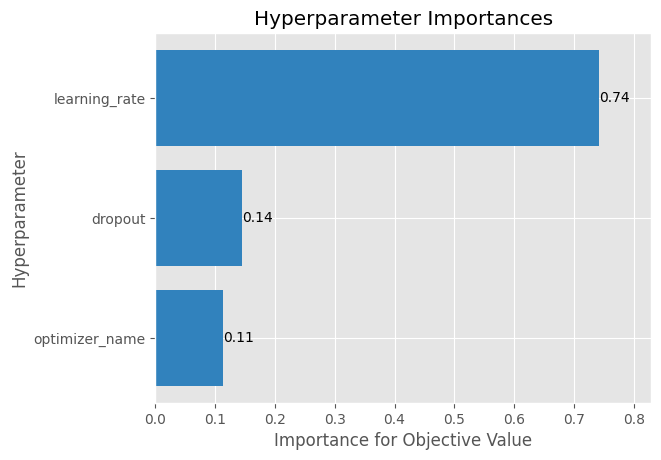

time: 209 ms (started: 2023-04-23 13:31:51 +00:00)


In [11]:
#shows the importance of each hyperparameter

optuna.visualization.matplotlib.plot_param_importances(study)
fig.show()

In [22]:

from torchvision import datasets, transforms
import torch.utils.data as data
from torch.utils.data import Subset

# Set the random seed for reproducibility
torch.manual_seed(42)

# Load and transform the data
train_dataset = datasets.ImageFolder(root='data/train', transform=auto_transforms)
test_dataset = datasets.ImageFolder(root='data/test', transform=auto_transforms)
val_dataset = datasets.ImageFolder(root='data/valid', transform=auto_transforms)

# load the data and shuffle the training data
train_dataloader = data.DataLoader(train_dataset, batch_size=32, shuffle=True,pin_memory=True, num_workers=4)
test_dataloader = data.DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True,num_workers=4)
valid_dataloader = data.DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True,num_workers=4)

time: 50.1 ms (started: 2023-04-23 13:40:07 +00:00)


In [23]:
import timm 
#look up all the maxvit models in timm's library
mvitv2_models = timm.list_models('*mvitv2*')
mvitv2_models

['mvitv2_base',
 'mvitv2_large',
 'mvitv2_small',
 'mvitv2_small_cls',
 'mvitv2_tiny']

time: 3.37 ms (started: 2023-04-23 13:40:07 +00:00)


In [24]:
#to create this code, timm's library has been used. 

import timm 
import torch
import torch.nn as nn

# Set the random seed for reproducibility
torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

#create the model and change number of classes to 8
model = timm.create_model('mvitv2_large', pretrained=True, num_classes=8)

#freeze the weights
for param in model.parameters():
    param.requires_grad = False
   
# unfreeze the last fc layer
for param in model.head.parameters():
    param.requires_grad = True

model.to(device)


MultiScaleVit(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 144, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
  )
  (stages): ModuleList(
    (0): MultiScaleVitStage(
      (blocks): ModuleList(
        (0): MultiScaleBlock(
          (norm1): LayerNorm((144,), eps=1e-06, elementwise_affine=True)
          (attn): MultiScaleAttention(
            (qkv): Linear(in_features=144, out_features=432, bias=True)
            (proj): Linear(in_features=144, out_features=144, bias=True)
            (pool_q): Conv2d(72, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=72, bias=False)
            (norm_q): LayerNorm((72,), eps=1e-06, elementwise_affine=True)
            (pool_k): Conv2d(72, 72, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1), groups=72, bias=False)
            (norm_k): LayerNorm((72,), eps=1e-06, elementwise_affine=True)
            (pool_v): Conv2d(72, 72, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1), groups=72, bias=False)
            (norm_v): L

time: 3.83 s (started: 2023-04-23 13:40:11 +00:00)


In [26]:
# Print a summary using torchinfo (uncomment for actual output)

model = model
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MultiScaleVit (MultiScaleVit)                                [32, 3, 224, 224]    [32, 8]              --                   Partial
├─PatchEmbed (patch_embed)                                   [32, 3, 224, 224]    [32, 3136, 144]      --                   False
│    └─Conv2d (proj)                                         [32, 3, 224, 224]    [32, 144, 56, 56]    (21,312)             False
├─ModuleList (stages)                                        --                   --                   --                   False
│    └─MultiScaleVitStage (0)                                [32, 3136, 144]      [32, 3136, 288]      --                   False
│    │    └─ModuleList (blocks)                              --                   --                   (662,976)            False
│    └─MultiScaleVitStage (1)                                [32, 3136, 288]      [3

time: 374 ms (started: 2023-04-23 13:40:20 +00:00)


In [27]:
# define optimizers and loss function and use the best hyperparameters found during the HP tuning

# Set the random seed for reproducibility
torch.manual_seed(42)

# Setup device agnostic code
criterion = nn.CrossEntropyLoss()
optimizer =  torch.optim.AdamW(model.parameters(), lr=0.0013813270726579733)

time: 6.51 ms (started: 2023-04-23 13:40:24 +00:00)


In [28]:
#in this code we apply mixed precision training to allow for faster training and use early stopping to prevent overfitting 

# Set the random seed for reproducibility
torch.manual_seed(42)

import matplotlib.pyplot as plt
import torch
# Creates once at the beginning of training
scaler = torch.cuda.amp.GradScaler()

# Lists to store the loss and accuracy values
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Train the model
num_epochs = 20
best_val_loss = float('inf')
patience = 5
for epoch in range(num_epochs):
    # Train the model
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for data in train_dataloader:
        inputs, labels = data[0].to(device), data[1].to(device) # Move data to device
        optimizer.zero_grad()
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()    # Scale the gradients
        scaler.step(optimizer)           # Update the model parameters
        scaler.update()                  # Update the scaler
        train_loss += loss.item() * inputs.size(0)
        train_acc += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

    # Evaluate the model
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for data in valid_dataloader:
            inputs, labels = data[0].to(device), data[1].to(device) # Move data to device
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_acc += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

    # Print the results for this epoch
    train_loss /= len(train_dataloader.dataset)
    train_acc /= len(train_dataloader.dataset)
    val_loss /= len(valid_dataloader.dataset)
    val_acc /= len(valid_dataloader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Save the loss and accuracy values
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Check if the current validation loss is the best seen so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = model.state_dict()
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1

    # Stop training if the validation loss has not improved for `patience` epochs
    if epochs_since_improvement == patience:
        print(f"No improvement for {patience} epochs, stopping training.")
        break

Epoch 1/20: Train Loss: 0.9616, Train Acc: 0.6575, Val Loss: 0.8519, Val Acc: 0.6972
Epoch 2/20: Train Loss: 0.8151, Train Acc: 0.7025, Val Loss: 0.8254, Val Acc: 0.7014
Epoch 3/20: Train Loss: 0.7677, Train Acc: 0.7222, Val Loss: 0.7825, Val Acc: 0.7155
Epoch 4/20: Train Loss: 0.7397, Train Acc: 0.7297, Val Loss: 0.7780, Val Acc: 0.7155
Epoch 5/20: Train Loss: 0.7175, Train Acc: 0.7356, Val Loss: 0.7802, Val Acc: 0.7178
Epoch 6/20: Train Loss: 0.7006, Train Acc: 0.7397, Val Loss: 0.7583, Val Acc: 0.7240
Epoch 7/20: Train Loss: 0.6825, Train Acc: 0.7494, Val Loss: 0.7652, Val Acc: 0.7282
Epoch 8/20: Train Loss: 0.6741, Train Acc: 0.7537, Val Loss: 0.7547, Val Acc: 0.7247
Epoch 9/20: Train Loss: 0.6645, Train Acc: 0.7551, Val Loss: 0.7518, Val Acc: 0.7266
Epoch 10/20: Train Loss: 0.6552, Train Acc: 0.7600, Val Loss: 0.7399, Val Acc: 0.7377
Epoch 11/20: Train Loss: 0.6473, Train Acc: 0.7617, Val Loss: 0.7395, Val Acc: 0.7332
Epoch 12/20: Train Loss: 0.6385, Train Acc: 0.7660, Val Loss: 0

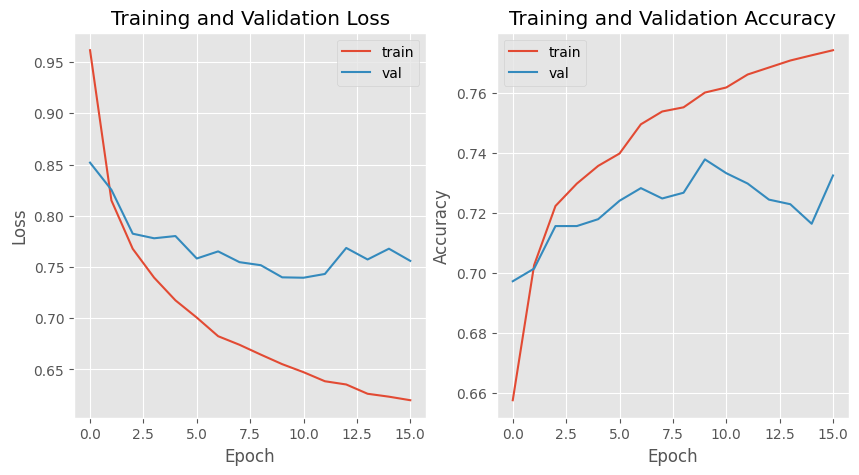

time: 238 ms (started: 2023-04-23 14:12:27 +00:00)


In [29]:
# Plot the validation and training loss and accuracy values
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_losses, label='train')
ax[0].plot(val_losses, label='val')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].legend()
ax[1].plot(train_accs, label='train')
ax[1].plot(val_accs, label='val')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].legend()
plt.show()

In [30]:
#evaluate on test set and calculate metrics, we are calculating macro f1 and roc-auc score, because of the heavily imbalanced dataset
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, classification_report
import pandas as pd
import numpy as np

model.eval()
test_loss = 0.0
test_acc = 0.0
y_true = []
y_scores = []
y_pred = []

with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data[0].to(device), data[1].to(device) # Move data to device
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        test_acc += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

        # Append predictions to lists
        y_true.extend(labels.cpu().numpy())
        y_scores.extend(outputs.cpu().numpy())
        y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())

test_loss /= len(test_dataloader.dataset)
test_acc /= len(test_dataloader.dataset)

# Calculate metrics

import warnings
from sklearn.exceptions import UndefinedMetricWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(8)], digits=4)

conf_mat = confusion_matrix(y_true, y_pred)
roc_auc = roc_auc_score(np.array(pd.get_dummies(y_true)), y_scores, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Calculate other metrices
n_classes = conf_mat.shape[0]
sensitivity = 0
specificity = 0
for i in range(n_classes):
    tp = conf_mat[i,i]
    fn = np.sum(conf_mat[i,:]) - tp
    fp = np.sum(conf_mat[:,i]) - tp
    tn = np.sum(conf_mat) - tp - fn - fp
    sensitivity += tp / (tp + fn) * np.sum(conf_mat[i,:])
    specificity += tn / (tn + fp) * np.sum(conf_mat[i,:])
sensitivity /= np.sum(conf_mat)
specificity /= np.sum(conf_mat)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print("Classification Report:")
print(report)

Test Loss: 0.7931
Test Accuracy: 0.7167
Sensitivity: 0.7167
Specificity: 0.8625
ROC-AUC: 0.8985
F1-score: 0.5424
Classification Report:
              precision    recall  f1-score   support

           0     0.3196    0.4133    0.3605        75
           1     0.6530    0.7427    0.6949       342
           2     0.5108    0.5201    0.5154       273
           3     0.4375    0.3182    0.3684        22
           4     0.7098    0.4328    0.5377       469
           5     0.8023    0.9054    0.8507      1300
           6     0.6522    0.2344    0.3448        64
           7     0.8824    0.5357    0.6667        28

    accuracy                         0.7167      2573
   macro avg     0.6209    0.5128    0.5424      2573
weighted avg     0.7146    0.7167    0.7044      2573

time: 14.8 s (started: 2023-04-23 14:12:27 +00:00)


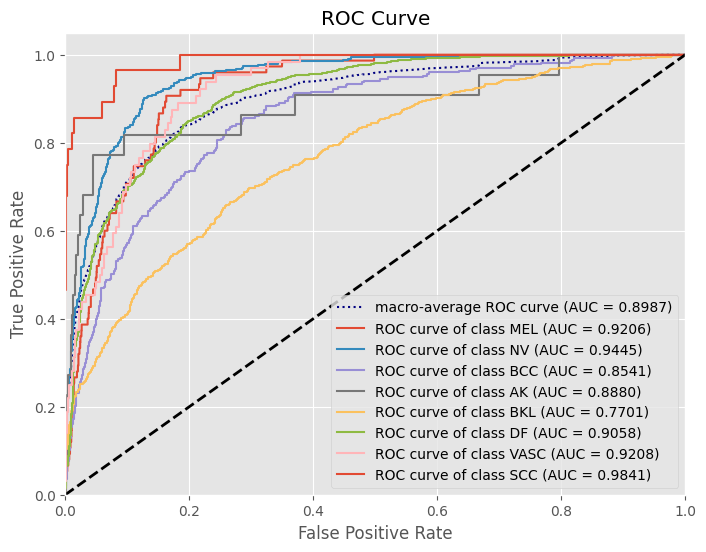

time: 164 ms (started: 2023-04-23 14:12:42 +00:00)


In [31]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define a dictionary mapping class indices to class names
class_dict = {0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AK', 4: 'BKL', 5: 'DF', 6: 'VASC', 7: 'SCC'}

# Convert the y_true and y_scores lists to arrays
y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Calculate the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(y_true))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (AUC = {0:0.4f})'.format(roc_auc["macro"]), color='navy', linestyle=':')

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (AUC = {1:0.4f})'.format(class_dict[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

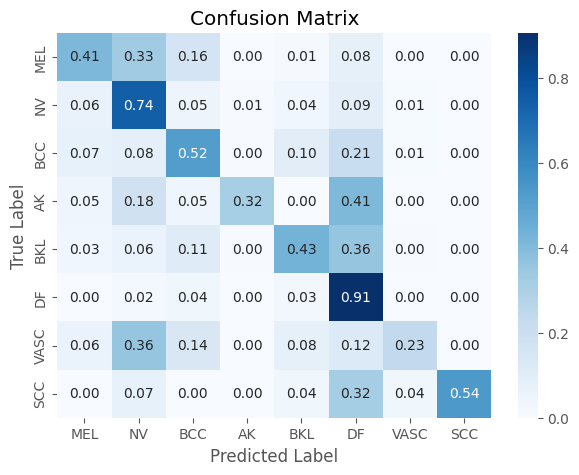

time: 222 ms (started: 2023-04-23 14:12:42 +00:00)


In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a dictionary mapping class indices to class names
class_dict = {0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AK', 4: 'BKL', 5: 'DF', 6: 'VASC', 7: 'SCC'}

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(conf_mat / conf_mat.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2f', cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
class_labels = sorted(list(class_dict.keys()), key=lambda x: int(x))
ax.xaxis.set_ticklabels([class_dict[label] for label in class_labels])
ax.yaxis.set_ticklabels([class_dict[label] for label in class_labels])
plt.show()

